In [2]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff
from natsort import natsort_keygen, natsorted

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_processed = data_dir / 'processed'


In [6]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'13cyc_3D'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

In [7]:
df_imgs.head()

,Condition,FOV,Z,Path
0,100nM,FW1,z1,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
1,100nM,FW1,z2,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
2,100nM,FW1,z3,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
3,100nM,FW1,z4,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
4,100nM,FW1,z5,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...


# Test code 

In [6]:
# Read masks paths 
mask_dir = data_dir / '13cyc_3D'  / 'imgs' / 'masks_3D'
mask_filt_dir = data_dir / '13cyc_3D'   / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [7]:
masks_path

defaultdict(dict,
            {'100nM_FW1': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/100nM_FW1.tif'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/Nuclei_100nM_FW1.tif')},
             '100nM_FW2': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/100nM_FW2.tif'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/Nuclei_100nM_FW2.tif')},
             'control_FW1': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/control_FW1.tif'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/Nuclei_control_FW1.tif')},
             'control_FW2': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc_3D/imgs/masks_3D/control_FW2.tif'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revisi

In [8]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join([row.Condition, row.FOV])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    break

In [9]:
# img = skimage.io.imread(mask_cyto_path)

In [11]:
# img.shape

# QC Segmentation

In [63]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=25000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # # Filter out mask touching border
    # mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    # mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered = mask_nuclei 
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=4000)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [64]:
# Read masks paths 
mask_dir = data_dir / '13cyc_3D'  / 'imgs' / 'masks_3D'
mask_filt_dir = data_dir / '13cyc_3D'   / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [67]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join([row.Condition, row.FOV])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    mask_nuclei = mask_nuclei[:mask_cyto.shape[0], :mask_cyto.shape[1]]
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

In [66]:
import napari

viewer = napari.view_labels(mask_cyto)
viewer.add_labels(cell)

<Labels layer 'cell' at 0x1af77098590>

In [62]:
import napari

viewer = napari.view_labels(mask_nuclei)
viewer.add_labels(nuclei)

<Labels layer 'nuclei' at 0x1af786c4dd0>

# 3D PLA extraction

In [8]:
df_meta_path = data_dir /'13cyc_3D'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

In [9]:
import PLA

PPI_save_path =  data_dir / '13cyc_3D'  / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

PPI_imgs_path =  data_dir / '13cyc_3D'  / 'PPI_imgs'
PPI_imgs_path.mkdir(parents=True, exist_ok=True)

In [10]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break


['Hoechst' 'Sox2/Oct4' 'NF-Kb/p-P90rsk' 'Hoechst' 'SIRT1/P53' 'TRAIL/DR5'
 'Hoechst' 'Cyclin D1/CDK4' 'Bim/Tom20' 'Hoechst' 'EGFR/GRB2' 'FoxO1/AKT'
 'Hoechst' 'p-ERK/c-MYC' 'Hoechst' 'Mcl-1/BAK' 'Hoechst' 'Cyclin E/CDK2'
 'Hoechst' 'AKT/Mtor' 'Hoechst' 'TEAD1/YAP' 'Hoechst' 'p-EGFR'
 'Phalloidin' 'Ki67' 'Hoechst' 'NBD-C6' 'COX IV' 'Hoechst'
 'Pan-cytokeratin' 'Hoechst' 'Concanavalin A' 'WGA']


In [11]:
PPI_markers = ['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',
 'Cyclin D1/CDK4', 'Bim/Tom20', 'EGFR/GRB2', 'FoxO1/AKT',
 'p-ERK/c-MYC', 'Mcl-1/BAK', 'Cyclin E/CDK2',
 'AKT/Mtor', 'TEAD1/YAP']

In [13]:
group = df_imgs.groupby(['Condition', 'FOV'])
n_limit = 1

for name, df_group in group:
    df_group = df_group.sort_values(['Z'], key=natsort_keygen())
    df_group = df_group.iloc[n_limit:-n_limit]
    paths = df_group.Path.tolist()
    
    imgs_spots = []
    imgs_wths = []
    imgs_raw = []
    pla_detect = PLA.PLA_detection_3D(paths)
    for PPI_pair in PPI_markers: 
        img_spot, img_wth, _, img = pla_detect.detect_spot(PPI_pair , thres=0.02, min_radius=2)
        imgs_spots.append(img_spot)
        imgs_wths.append(img_wth)
        imgs_raw.append(img)
    
    # Save imgs
    for i in range(len(imgs_spots)):
        file_path = PPI_imgs_path / ('_'.join(row[1:3]) + f'_{i}' + '_raw.tiff')
        tiff.imwrite(file_path, imgs_raw[i],  bigtiff=True)
        file_path = PPI_imgs_path / ('_'.join(row[1:3]) + f'_{i}' + '_processed.tiff')
        tiff.imwrite(file_path, imgs_wths[i],  bigtiff=True)
        file_path = PPI_imgs_path / ('_'.join(row[1:3]) + f'_{i}' + '_detected.tiff')
        tiff.imwrite(file_path, imgs_spots[i],  bigtiff=True)

    # Save PPI dict
    fname = '_'.join(name)+'.pkl'
    pla_detect.save_pickle(PPI_save_path / fname)


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29485568,    52003], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29511285,    26286], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29530225,     7346], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29331382,   206189], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29445744,    91827], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29512572,    24999], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29408880,   128691], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29485579,    51992], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29463650,    73921], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29511447,    26124], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29501109,    36462], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29518840,    18731], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29514506,    23065], dtype=int64))
File exist. Deleted


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29507741,    57178], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29534088,    30831], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29555679,     9240], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29278785,   286134], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29446716,   118203], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29531750,    33169], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29396786,   168133], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29486183,    78736], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29476058,    88861], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29530914,    34005], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29517236,    47683], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29542531,    22388], dtype=int64))


Reading images:   0%|          | 0/8 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/8 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29539464,    25455], dtype=int64))
File exist. Deleted


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29484551,   133819], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29533318,    85052], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29598069,    20301], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29241289,   377081], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29390647,   227723], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29568582,    49788], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29274261,   344109], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29526196,    92174], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29573315,    45055], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29550057,    68313], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29528443,    89927], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29574073,    44297], dtype=int64))


Reading images:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/6 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29568340,    50030], dtype=int64))
File exist. Deleted


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29528701,    87964], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29569857,    46808], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29604622,    12043], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29352632,   264033], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29488217,   128448], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29581735,    34930], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29420435,   196230], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29541168,    75497], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29533561,    83104], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29569999,    46666], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29559560,    57105], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29584231,    32434], dtype=int64))


Reading images:   0%|          | 0/7 [00:00<?, ?it/s]

Detecting PPI spots:   0%|          | 0/7 [00:00<?, ?it/s]

(array([0, 1], dtype=uint8), array([29585463,    31202], dtype=int64))
File exist. Deleted


# Assign PPI to cell 

In [14]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import scipy 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def get_NN_radius(data, r):
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=True, sort_results=True)

    # Put in dataframe format
    neighbours = pd.DataFrame(m[1].tolist(), index = data.index)
    
    A = fit.radius_neighbors_graph(data)
    return neighbours, A

def plot_spot_on_image(spots, spacing, radius):
    spot_img = np.zeros(spots.max(0))
    coords = (spots[:, :3] / spacing).astype(int)
    r = radius  # shorthand
    for coord in coords:
        slc = tuple(slice(x-r, x+r) if i != 0 else slice(x, x+1) for i, x in enumerate(coord) )
        spot_img[slc] = 1
    return spot_img

def plot_label_on_image(spots, spacing, radius, labels):
    spot_img = np.zeros(spots.max(0))
    coords = (spots[:, :3] / spacing).astype(int)
    r = radius  # shorthand
    for i, coord in enumerate(coords):
        slc = tuple(slice(x-r, x+r) if i != 0 else slice(x, x+1) for i, x in enumerate(coord) )
        spot_img[slc] = labels[i]
    return spot_img

def create_PPI_df(df_loc_filtered, mask_cyto, mask_nuclei, name):
    _, y_max, x_max = mask_cyto.shape
    z, y, x = df_loc_filtered['z'].to_numpy(), df_loc_filtered['y'].to_numpy(), df_loc_filtered['x'].to_numpy()
    y = np.clip(y, a_min=0, a_max=y_max-1)
    x = np.clip(x, a_min=0, a_max=x_max-1)

    labels = mask_cyto[z, y, x]
    labels_nuclei = mask_nuclei[z, y, x].astype(np.uint8)
    
    df_per_cell = pd.DataFrame({'Cell': labels, 'Nuclei': labels_nuclei, 'z': z, 'y':y, 'x':x})
    df_per_cell['PPI'] = name
    return df_per_cell

In [15]:
df_meta_path = data_dir /'13cyc_3D'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

PPI_save_path =  data_dir / '13cyc_3D'  / 'PPI'

In [16]:
mask_filt_dir = data_dir /'13cyc_3D'  / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [17]:
group = df_imgs.groupby(['Condition', 'FOV'])

for names, df_group in group:
    name = '_'.join(names)
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    
    # Read mask
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    _, y_max, x_max = mask_cyto.shape
    print(len(np.unique(mask_cyto)))

745
743
965
592


In [18]:
group = df_imgs.groupby(['Condition', 'FOV'])

for names, df_group in group:
    name = '_'.join(names)
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    
    # Read mask
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    _, y_max, x_max = mask_cyto.shape

    df_PPIs = []
    for k in ['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',
            'Cyclin D1/CDK4', 'Bim/Tom20', 'EGFR/GRB2', 'FoxO1/AKT',
            'p-ERK/c-MYC', 'Mcl-1/BAK', 'Cyclin E/CDK2',
            'AKT/Mtor', 'TEAD1/YAP']:
        
        PPI_loc = PPI_dict[k][:, :3].astype(np.uint32)
        
        # Get PPI loc in panda dataframe format
        df_loc = pd.DataFrame(PPI_loc, columns=['z', 'y', 'x'])

        # Get dot neighboring graph with user defined radius
        nei, A = get_NN_radius(df_loc[['y', 'x']], r=2.5)

        # Assign new labels based on connected components label
        labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
        df_loc['CC_label'] = labels

        # Group by CC and extract mean position
        df_loc_filtered = df_loc.groupby(['CC_label']).mean().astype(np.uint32)
        
        # Extract Cell info per PPI
        df_PPI = create_PPI_df(df_loc_filtered, mask_cyto, mask_nuclei, k)
        df_PPIs.append(df_PPI)
    df_PPI = pd.concat(df_PPIs)
    df_PPI['Condition'] = names[0]
    df_PPI['FOV'] = names[1]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_PPI.to_csv(path, index=False)

# PPI Stats

In [19]:
# Read PPI
PPI_save_path =   data_dir / '13cyc_3D' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cell']).size()
df_cell = pd.DataFrame({'Count Cell': g}).reset_index()
df_cell = df_cell[df_cell.Cell != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [20]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count       mean        std  min   25%   50%  \
Condition PPI                                                             
100nM     AKT/Mtor        1486.0   2.591521   2.786095  0.0   0.0   2.0   
          Bim/Tom20       1486.0   3.288022   2.930247  0.0   1.0   3.0   
          Cyclin D1/CDK4  1486.0   9.466353   6.564050  0.0   5.0   8.0   
          Cyclin E/CDK2   1486.0   5.546433   4.965897  0.0   2.0   5.0   
          EGFR/GRB2       1486.0  15.493271  10.123328  0.0   9.0  14.0   
          FoxO1/AKT       1486.0   7.970390   6.289037  0.0   3.0   7.0   
          Mcl-1/BAK       1486.0   3.917227   3.645284  0.0   1.0   3.0   
          NF-Kb/p-P90rsk  1486.0   2.934051   2.719865  0.0   1.0   2.0   
          SIRT1/P53       1486.0   0.942799   1.430344  0.0   0.0   1.0   
          Sox2/Oct4       1486.0   4.000000   3.369900  0.0   2.0   3.0   
          TEAD1/YAP       1486.0   3.310229   3.269076  0.0   1.0   2.0   
          TRAIL/DR5       1486.0  28.617766  19.359037  0.0  15.0  26.0   
          p-ERK/c-MYC     1486.0  11.927322  14.430564  0.0   2.0   7.0   
control   AKT/Mtor        1554.0   4.989060   4.824733  0.0   1.0   4.0   
          Bim/Tom20       1554.0   4.067568   3.609024  0.0   2.0   3.0   
          Cyclin D1/CDK4  1554.0  13.617761   8.300496  0.0   8.0  12.0   
          Cyclin E/CDK2   1554.0   7.008366   5.422336  0.0   3.0   6.0   
          EGFR/GRB2       1554.0  25.978764  14.968400  0.0  15.0  24.0   
          FoxO1/AKT       1554.0  10.201416   8.953552  0.0   4.0   8.0   
          Mcl-1/BAK       1554.0   5.665380   4.352024  0.0   2.0   5.0   
          NF-Kb/p-P90rsk  1554.0   4.825611   4.273169  0.0   2.0   4.0   
          SIRT1/P53       1554.0   1.860360   1.878934  0.0   0.0   1.0   
          Sox2/Oct4       1554.0   6.812098   5.356399  0.0   3.0   6.0   
          TEAD1/YAP       1554.0   4.212355   3.785280  0.0   2.0   3.0   
          TRAIL/DR5       1554.0  30.947233  22.945660  0.0  17.0  26.0   
          p-ERK/c-MYC     1554.0   8.651223  16.503721  0.0   0.0   2.0   

                            75%    max  
Condition PPI                           
100nM     AKT/Mtor         4.00   41.0  
          Bim/Tom20        5.00   31.0  
          Cyclin D1/CDK4  13.00   61.0  
          Cyclin E/CDK2    8.00   92.0  
          EGFR/GRB2       20.00   90.0  
          FoxO1/AKT       11.00   69.0  
          Mcl-1/BAK        6.00   52.0  
          NF-Kb/p-P90rsk   4.00   18.0  
          SIRT1/P53        1.00   28.0  
          Sox2/Oct4        6.00   27.0  
          TEAD1/YAP        5.00   28.0  
          TRAIL/DR5       39.00  210.0  
          p-ERK/c-MYC     16.75  134.0  
control   AKT/Mtor         7.00   29.0  
          Bim/Tom20        6.00   50.0  
          Cyclin D1/CDK4  18.00  110.0  
          Cyclin E/CDK2   10.00   63.0  
          EGFR/GRB2       34.00  162.0  
          FoxO1/AKT       14.00  132.0  
          Mcl-1/BAK        8.00   24.0  
          NF-Kb/p-P90rsk   7.00   51.0  
          SIRT1/P53        3.00   11.0  
          Sox2/Oct4        9.00   60.0  
          TEAD1/YAP        6.00   45.0  
          TRAIL/DR5       40.00  402.0  
          p-ERK/c-MYC     10.00  268.0

In [21]:
# Filter out by maximum number of counts per cell
min_count = 10
max_count = 50

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


C:\Users\thu71\AppData\Local\Temp\ipykernel_58296\2618801339.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,2427.000000,2427.000000,2427.000000
mean,94.386073,18.188298,76.197775
std,45.365136,46.360069,44.292548
min,11.000000,0.000000,0.000000
25%,60.000000,0.000000,43.000000
50%,90.000000,0.000000,74.000000
75%,124.000000,0.000000,105.000000
max,273.000000,268.000000,273.000000


In [24]:
from statannotations.Annotator import Annotator
import seaborn as sns 

def plot(plotting, figsize=(15,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

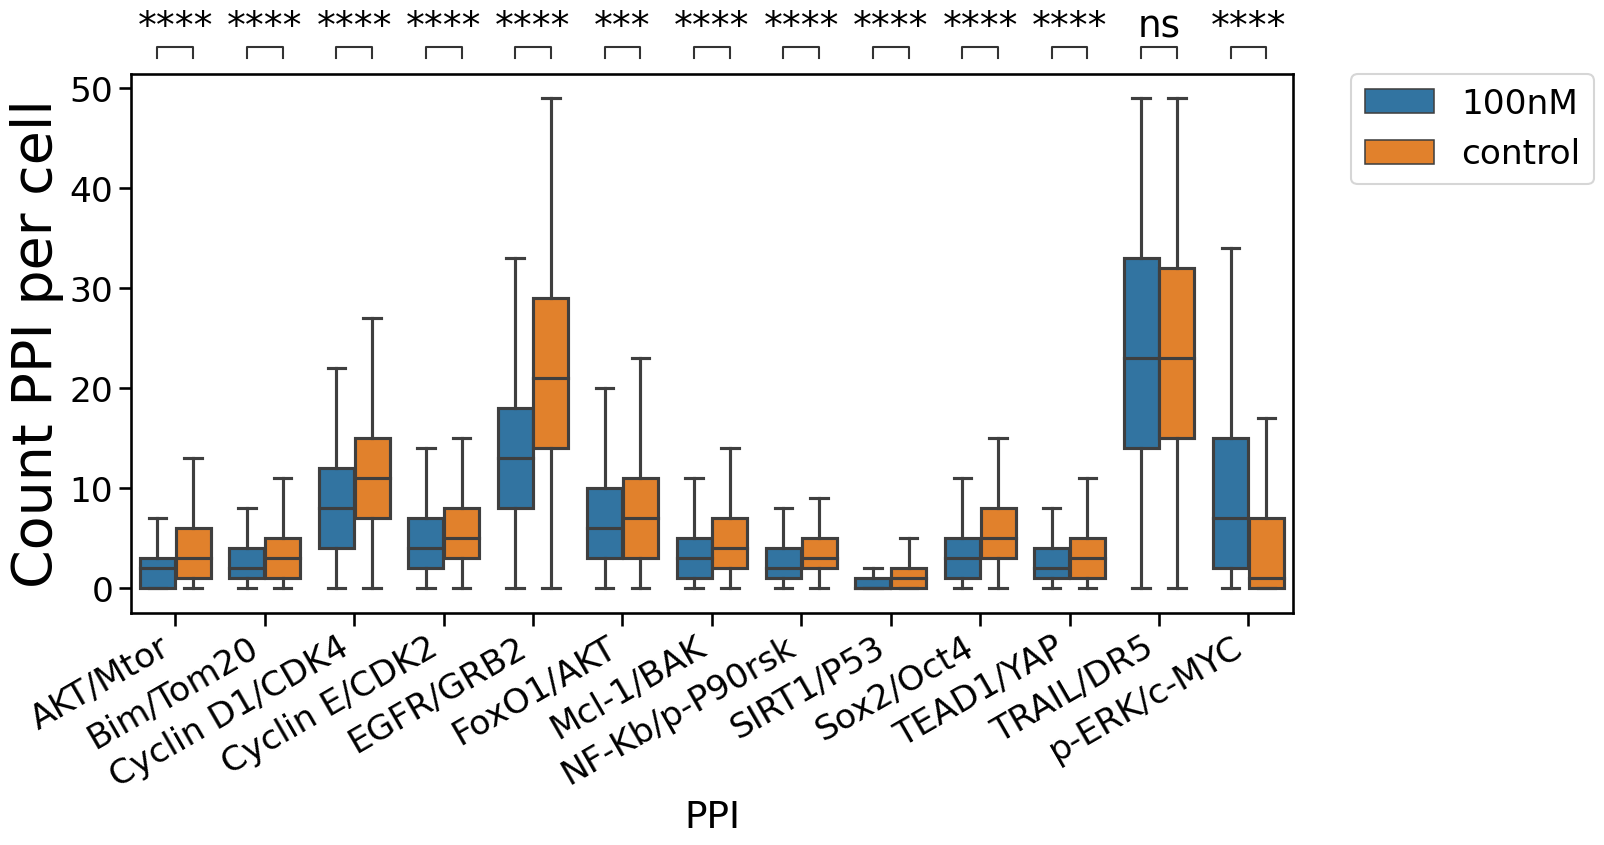

In [25]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

# Generate 3D PPI network

In [29]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def plot_tri_simple(ax, points, tri):
    for tr in tri.simplices:
        pts = points[tr, :]
        ax.plot3D(pts[[0,1],0], pts[[0,1],1], pts[[0,1],2], color='g', lw='0.1')
        ax.plot3D(pts[[0,2],0], pts[[0,2],1], pts[[0,2],2], color='g', lw='0.1')
        ax.plot3D(pts[[0,3],0], pts[[0,3],1], pts[[0,3],2], color='g', lw='0.1')
        ax.plot3D(pts[[1,2],0], pts[[1,2],1], pts[[1,2],2], color='g', lw='0.1')
        ax.plot3D(pts[[1,3],0], pts[[1,3],1], pts[[1,3],2], color='g', lw='0.1')
        ax.plot3D(pts[[2,3],0], pts[[2,3],1], pts[[2,3],2], color='g', lw='0.1')

    ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
    
def create_network(df, t=50, scale=0.2):   
    z,y,x = df['z'].to_numpy()*scale, df['y'].to_numpy(), df['x'].to_numpy()

    # Get coordinates
    coordinates = np.vstack([x, y, z]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

In [30]:
PPI_save_path =  data_dir / '13cyc_3D' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()

In [31]:
df

,Cell,Nuclei,z,y,x,PPI,Condition,FOV,Labels
0,459,212,3,875,4048,Sox2/Oct4,100nM,FW1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,704,177,2,1665,2260,Sox2/Oct4,100nM,FW1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,827,15,3,1991,6660,Sox2/Oct4,100nM,FW1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,0,225,2,2981,8196,Sox2/Oct4,100nM,FW1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,1390,34,3,3192,7902,Sox2/Oct4,100nM,FW1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...
88765,768,90,6,3188,5062,TEAD1/YAP,control,FW2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
88766,706,39,6,2922,3099,TEAD1/YAP,control,FW2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
88767,843,0,6,3277,4152,TEAD1/YAP,control,FW2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
88768,710,0,6,2991,459,TEAD1/YAP,control,FW2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [34]:
graph_save_path =  data_dir / '13cyc_3D' / 'graphs' / 'raw'
graph_save_path .mkdir(parents=True, exist_ok=True)

scale = 0.4/0.18872

group = df.groupby(['Condition', 'FOV', 'Cell'])
for name, df_group in group:
    if name[2] == 0:
        continue
    if len(df_group) < 50:
        continue
    
    g = create_network(df_group, t=70, scale=scale)
    if nx.number_of_isolates(g)>0:
        print('Isolated nodes')
    
    # Save pgrahs
    save_path = graph_save_path / ('_'.join([str(n) for n in name])+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(g, f, protocol=pickle.HIGHEST_PROTOCOL)